In [1]:
# ESSENTIAL
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import random
import os
import logging
from datetime import datetime
from itertools import combinations

# PORTFOLIO
import six
import tools
from algo import Algo
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False

# ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# CUSTOM
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wrappers import bitfinex as bfx
from wrappers import technical_analysis as ta

%matplotlib inline

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def get_trade_history_from_date(cp, _from):
    
    # connect to db
    conn = sqlite3.connect('../db/crypto.db')
    
    # get trade history per currency pair and date specified
    get_data_query = '''
    
    SELECT date, currency_pair, rate, amount
    FROM trade_history
    WHERE currency_pair="%s"
    AND date >= %s;
    
    ''' % (cp, _from)
    
    # read into df and close connection
    df = pd.read_sql(get_data_query, conn)
    conn.close()
    
    return df

# parse out performance summary from portfolio object
def olps_stats(df):
    
    for name, r in df.results.iteritems():
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
    
    return df

In [3]:
class ONS(Algo):
    """
    Online newton step algorithm.

    Reference:
        A.Agarwal, E.Hazan, S.Kale, R.E.Schapire.
        Algorithms for Portfolio Management based on the Newton Method, 2006.
        http://machinelearning.wustl.edu/mlpapers/paper_files/icml2006_AgarwalHKS06.pdf
    """

    REPLACE_MISSING = True

    def __init__(self, delta=0.125, beta=1., eta=0.):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super(ONS, self).__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta


    def init_weights(self, m):
        return np.ones(m) / m


    def init_step(self, X):
        m = X.shape[1]
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T


    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1./self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """ Projection of x to simplex indiced by matrix M. Uses quadratic programming.
        """
        m = M.shape[0]

        P = matrix(2*M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m,1)))
        A = matrix(np.ones((1,m)))
        b = matrix(1.)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol['x'])

class EG(Algo):
    """ Exponentiated Gradient (EG) algorithm by Helmbold et al.

    Reference:
        Helmbold, David P., et al.
        "On‐Line Portfolio Selection Using Multiplicative Updates."
        Mathematical Finance 8.4 (1998): 325-347.
    """

    def __init__(self, eta=0.05):
        """
        :params eta: Learning rate. Controls volatility of weights.
        """
        super(EG, self).__init__()
        self.eta = eta


    def init_weights(self, m):
        return np.ones(m) / m


    def step(self, x, last_b):
        b = last_b * np.exp(self.eta * x / sum(x * last_b))
        return b / sum(b)

In [11]:
# IMPORT BACKUP
df = pd.read_csv('../portfolio_optim_data_export_24hr.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', 1)

currency_pairs = ['USDT_ETH', 'USDT_BTC', 'USDT_LTC', 'USDT_ZEC', 'USDT_XMR', 'USDT_DASH', 'USDT_ETC']

# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

xdf = xdf.dropna()
print('xdf shape:', xdf.shape)

xdf shape: (315, 49)


In [12]:
price_df = xdf[[col for col in xdf.columns.tolist() if 'close' in col]]

#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0.5, 3.0))
scaled_prices = scaler.fit_transform(price_df).copy()
scaled_prices = pd.DataFrame(scaled_prices)
scaled_prices.columns = [col for col in price_df.columns.tolist()]

In [47]:
ons = ONS()
eg = EG()

In [48]:
ons = ons.run(scaled_prices)
eg = eg.run(scaled_prices)

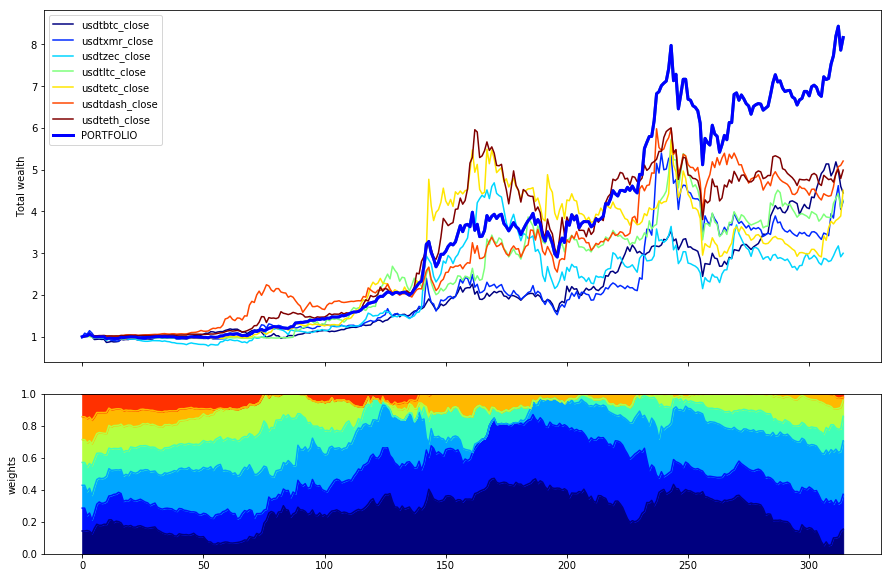

In [29]:
ons.plot(weights = True, figsize = (15, 10));

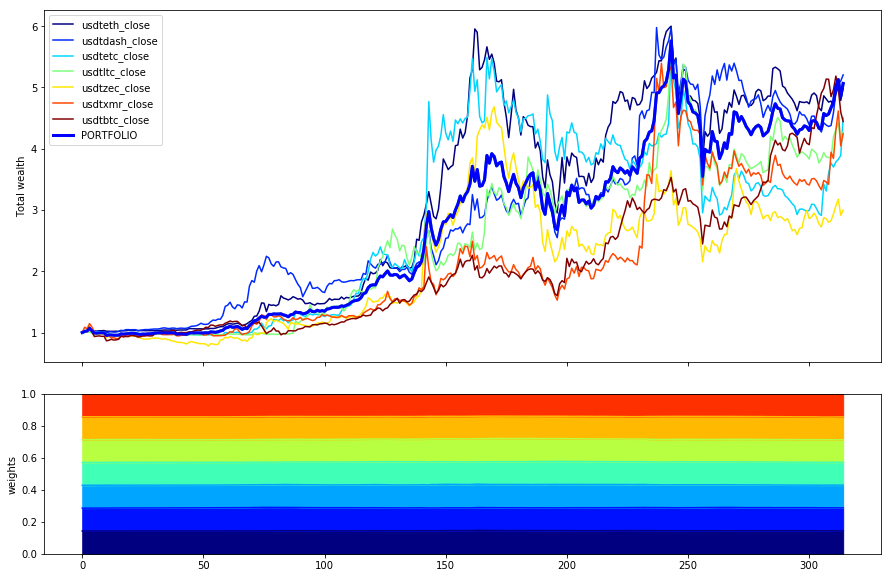

In [38]:
eg.plot(weights = True, figsize = (15, 10));

In [50]:
price_df.shape

(315, 7)

In [82]:
wealth = 50000
wealth_history = []
counter = 0

for i in range(90, price_df.shape[0]):
    
    # set the price df and date for the "today" of this iteration
    current_prices = price_df.iloc[:i,:]
    today = current_prices.index[-1]

    # init online newton step algo
    ons = ONS()
    ons = ons.run(current_prices)
    
    # get asset weights
    current_weights = ons.weights
    
    # if it is the first time, get n_assets by init wealth. otherwise, first calculate new wealth
    if counter == 0:
        n_assets_owned = (current_weights.loc[today] * wealth) / current_prices.loc[today]
    else:
        wealth = (n_assets_owned * current_prices.loc[today]).sum()
        n_assets_owned = (current_weights.loc[today] * wealth) / current_prices.loc[today]
    
    #if counter == 1: break
    wealth_history.append(wealth)
    counter += 1

In [91]:
today

Timestamp('2017-03-31 00:00:00')

In [96]:
n_eth_hodl = 50000 / price_df.loc[today].usdteth_close
n_btc_hodl = 50000 / price_df.loc[today].usdtbtc_close
hodl_eth = (price_df.usdteth_close * n_eth_hodl).loc[today:]
hodl_btc = (price_df.usdtbtc_close * n_btc_hodl).loc[today:]

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


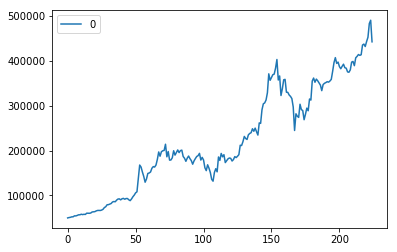

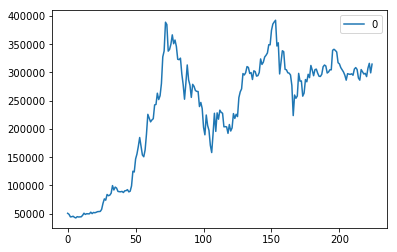

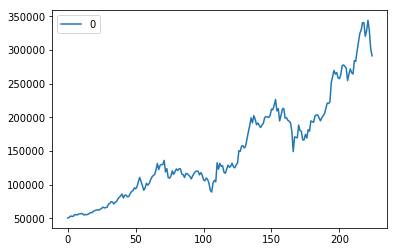

In [122]:
pd.DataFrame(wealth_history).plot()
pd.DataFrame(hodl_eth.reshape(-1,1)[1:]).plot()
pd.DataFrame(hodl_btc.reshape(-1,1)[1:]).plot();

In [119]:
wealth

442603.10724496923

In [120]:
hodl_btc[-1]

291386.96255201107

In [121]:
hodl_eth[-1]

314807.73871772183

# With Riskless Asset as Porfolio Option (USDT)

In [125]:
price_df['usdt'] = 1

In [127]:
wealth = 50000
wealth_history = []
counter = 0

for i in range(90, price_df.shape[0]):
    
    # set the price df and date for the "today" of this iteration
    current_prices = price_df.iloc[:i,:]
    today = current_prices.index[-1]

    # init online newton step algo
    ons = ONS()
    ons = ons.run(current_prices)
    
    # get asset weights
    current_weights = ons.weights
    
    # if it is the first time, get n_assets by init wealth. otherwise, first calculate new wealth
    if counter == 0:
        n_assets_owned = (current_weights.loc[today] * wealth) / current_prices.loc[today]
    else:
        wealth = (n_assets_owned * current_prices.loc[today]).sum()
        n_assets_owned = (current_weights.loc[today] * wealth) / current_prices.loc[today]
    
    #if counter == 1: break
    wealth_history.append(wealth)
    counter += 1

In [131]:
from pandas import Timestamp
today = Timestamp('2017-03-31 00:00:00')

In [132]:
n_eth_hodl = 50000 / price_df.loc[today].usdteth_close
n_btc_hodl = 50000 / price_df.loc[today].usdtbtc_close
hodl_eth = (price_df.usdteth_close * n_eth_hodl).loc[today:]
hodl_btc = (price_df.usdtbtc_close * n_btc_hodl).loc[today:]

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


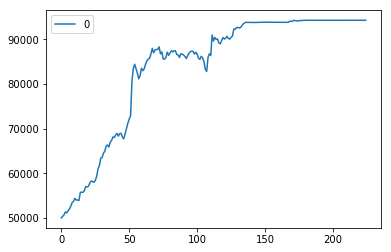

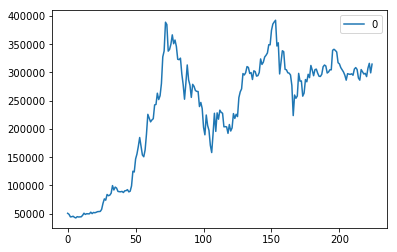

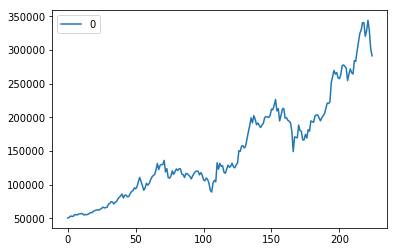

In [133]:
pd.DataFrame(wealth_history).plot()
pd.DataFrame(hodl_eth.reshape(-1,1)[1:]).plot()
pd.DataFrame(hodl_btc.reshape(-1,1)[1:]).plot();

In [134]:
print('Porfolio:', wealth)
print('Hodl BTC:', hodl_btc[-1])
print('Hodl ETH:', hodl_eth[-1])

Porfolio: 94287.0947118
Hodl BTC: 291386.962552
Hodl ETH: 314807.738718


In [135]:
ons = ONS().run(price_df)

# Test On All Available Coins

In [103]:
currency_pairs = ['USDT_BTC', 'USDT_LTC', 'USDT_ETH',
                  'USDT_ETC', 'USDT_ZEC', 'USDT_XMR',
                  'USDT_DASH', 'USDT_SAN', 'USDT_OMG',
                  'USDT_BCH', 'USDT_NEO', 'USDT_QTUM'
                 ]

currency_pairs = ['USDT_IOTA']

xdf = pd.DataFrame()

# get data
for cp in currency_pairs:
    
    print('\n\nStarting:', cp, '\n')
    
    # get all trades from 2017
    df = get_trade_history_from_date(cp, 1483228800)
    
    # 24 HOURS
    df = ta.get_ticks_from_df(df, '24H').iloc[:,:7]
    df['currency_pair'] = cp
    xdf = xdf.append(df)
    
    del df



Starting: USDT_IOTA 

converting to OHLC


In [104]:
# # #df.to_csv('all_coins_except_iota_ons_testing_export.csv')

# tdf = pd.read_csv('all_coins_except_iota_ons_testing_export.csv')

# tdf.index = pd.to_datetime(tdf.date)
# tdf = tdf.drop('date', 1)
# xdf = xdf.append(tdf)
# xdf.index = pd.to_datetime(xdf.index)

In [110]:
df = xdf.copy()
df.shape

(2828, 8)

In [121]:
currency_pairs = ['USDT_BTC', 'USDT_LTC', 'USDT_ETH',
                  'USDT_ETC', 'USDT_ZEC', 'USDT_XMR',
                  'USDT_DASH', 'USDT_SAN', 'USDT_OMG',
                  'USDT_BCH', 'USDT_NEO', 'USDT_IOTA',
                  #'USDT_QTUM'
                 ]

# init a df with BTC dt index (prob has the most data)
xdf = pd.DataFrame(index = df[df.currency_pair == 'USDT_BTC'].index)

for cp in currency_pairs:
    
    # filter down to current cp and remove last col (currency_pair)
    tdf = df[df.currency_pair == cp].iloc[:,:-1]
    
    # clean up cp name and append to col names
    clean_cp = cp.lower().replace('_','')
    new_cols = [clean_cp + '_' + col for col in tdf.columns.tolist()]
    tdf.columns = new_cols
    
    # add to full df
    xdf = xdf.join(tdf, how = 'left')

print('xdf shape:', xdf.shape)

xdf shape: (320, 84)


In [123]:
# earliest date
xdf.dropna().head(1)

,usdtbtc_open,usdtbtc_high,usdtbtc_low,usdtbtc_close,usdtbtc_volume,usdtbtc_mean_trade_price,usdtbtc_median_trade_price,usdtltc_open,usdtltc_high,usdtltc_low,...,usdtneo_volume,usdtneo_mean_trade_price,usdtneo_median_trade_price,usdtiota_open,usdtiota_high,usdtiota_low,usdtiota_close,usdtiota_volume,usdtiota_mean_trade_price,usdtiota_median_trade_price
date,,,,,,,,,,,,,,,,,,,,,
2017-09-07,4592.0,4685.120074,4447.22235,4613.670582,29384.375932,4579.079677,4588.9,81.111,83.092,76.96,...,277599.844082,31.346571,30.772,0.73944,0.73999,0.61415,0.64789,3.127933e+07,0.675476,0.68595


In [124]:
coins = xdf[[col for col in xdf.columns.tolist() if 'qtum' not in col]]
price_df = coins[[col for col in coins.columns.tolist() if 'close' in col]]

price_df = price_df.dropna()

scaler = MinMaxScaler(feature_range = (0.5, 3.0))
scaled_prices = scaler.fit_transform(price_df).copy()
scaled_prices = pd.DataFrame(scaled_prices)
scaled_prices.columns = [col for col in price_df.columns.tolist()]

In [125]:
ons = ONS()
ons = ons.run(scaled_prices)

In [126]:
print(ons.summary())

Summary:
    Profit factor: 1.29
    Sharpe ratio: 1.30
    Information ratio (wrt UCRP): 2.33
    Annualized return: 15306.25%
    Annualized volatility: 438.13%
    Longest drawdown: 22 days
    Max drawdown: 73.46%
    Winning days: 47.7%
        


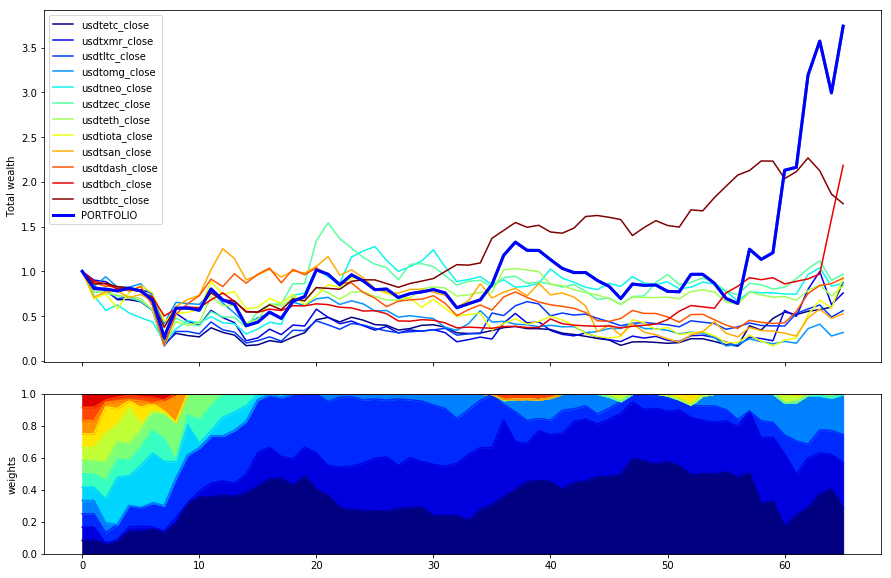

In [127]:
ons.plot(weights = True, figsize = (15, 10));

# Test ONS On All Coin Combos

In [129]:
all_coins = {
    
    0: 'USDT_BTC',
    1: 'USDT_LTC',
    2: 'USDT_ETH',
    3: 'USDT_ETC',
    4: 'USDT_ZEC',
    5: 'USDT_XMR',
    6: 'USDT_DASH',
    7: 'USDT_SAN',
    8: 'USDT_OMG',
    9: 'USDT_BCH',
    10: 'USDT_NEO',
    11: 'USDT_IOTA'
    
}

# create a range for iteration
iter_coins = np.arange(len(all_coins))

subsets = []

iter_coins_sum = int(len(iter_coins))
iter_coins_list = list(iter_coins)

for L in range(0, len(all_coins) + 1):
    print('starting iteration:', L)
    for subset in combinations(iter_coins_list, L):
        subsets.append(subset)

# get rid of first item (empty)
subsets = list(subsets[1:])

print('\nThere are %s possible combos total!' % len(subsets))

all_coin_combos = []

for s in subsets:
    combo = []
    for ss in s:
        combo.append(all_coins[ss])
    all_coin_combos.append(combo)

all_coin_combos = [c for c in all_coin_combos if len(c) >= 3]

print("But we're only using %s combos" % len(all_coin_combos))

starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5
starting iteration: 6
starting iteration: 7
starting iteration: 8
starting iteration: 9
starting iteration: 10
starting iteration: 11
starting iteration: 12

There are 4095 possible combos total!
But we're only using 4017 combos


In [130]:
all_results = []

for combo in all_coin_combos:
    
    r = {}
    
    combo = [col.lower().replace('_', '') + '_close' for col in combo]
    
    ons = ONS()
    ons = ons.run(scaled_prices[combo])
    
    r['coin_combo'] = str(combo)
    r['profit'] = ons.profit_factor
    r['sharpe'] = ons.sharpe
    r['return'] = ons.annualized_return
    r['max_drawdown'] = ons.max_drawdown
    
    all_results.append(r)
    
    if len(all_results) % 250 == 0: print(len(all_results))

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000


In [134]:
# top performing diversified basket
print(pd.DataFrame(all_results).sort_values('return', ascending = False).loc[2889])
pd.DataFrame(all_results).sort_values('return', ascending = False).loc[2889].coin_combo

coin_combo      ['usdtbtc_close', 'usdtxmr_close', 'usdtdash_c...
max_drawdown                                             0.650868
profit                                                    1.35121
return                                                    445.257
sharpe                                                    1.60293
Name: 2889, dtype: object


"['usdtbtc_close', 'usdtxmr_close', 'usdtdash_close', 'usdtsan_close', 'usdtbch_close', 'usdtneo_close', 'usdtiota_close']"

In [135]:
# top performing diversified basket
print(pd.DataFrame(all_results).sort_values('return', ascending = False).loc[3548])
pd.DataFrame(all_results).sort_values('return', ascending = False).loc[3548].coin_combo

coin_combo      ['usdtbtc_close', 'usdtzec_close', 'usdtxmr_cl...
max_drawdown                                             0.666116
profit                                                    1.34581
return                                                     426.09
sharpe                                                    1.58854
Name: 3548, dtype: object


"['usdtbtc_close', 'usdtzec_close', 'usdtxmr_close', 'usdtdash_close', 'usdtsan_close', 'usdtbch_close', 'usdtneo_close', 'usdtiota_close']"

In [132]:
pd.DataFrame(all_results).sort_values('return', ascending = False)[:25]

,coin_combo,max_drawdown,profit,return,sharpe
2889,"['usdtbtc_close', 'usdtxmr_close', 'usdtdash_c...",0.650868,1.351206,445.257229,1.602927
3548,"['usdtbtc_close', 'usdtzec_close', 'usdtxmr_cl...",0.666116,1.345814,426.089651,1.588536
2427,"['usdtxmr_close', 'usdtdash_close', 'usdtsan_c...",0.660658,1.334924,401.943501,1.540879
3218,"['usdtzec_close', 'usdtxmr_close', 'usdtdash_c...",0.674993,1.330158,373.816200,1.529814
3869,"['usdtbtc_close', 'usdteth_close', 'usdtzec_cl...",0.699032,1.324652,360.047217,1.483977
3513,"['usdtbtc_close', 'usdteth_close', 'usdtxmr_cl...",0.691017,1.317318,332.282403,1.453743
3704,"['usdteth_close', 'usdtzec_close', 'usdtxmr_cl...",0.707153,1.313022,319.364513,1.438198
2878,"['usdtbtc_close', 'usdtzec_close', 'usdtxmr_cl...",0.646078,1.350859,315.067483,1.625415
1961,"['usdtbtc_close', 'usdtxmr_close', 'usdtsan_cl...",0.621828,1.361520,314.031833,1.665597
2870,"['usdtbtc_close', 'usdtzec_close', 'usdtxmr_cl...",0.680699,1.310989,313.616531,1.470113


In [133]:
pd.DataFrame(all_results).sort_values('sharpe', ascending = False)[:25]

,coin_combo,max_drawdown,profit,return,sharpe
31,"['usdtbtc_close', 'usdtzec_close', 'usdtbch_cl...",0.641596,1.438528,47.035866,1.791546
53,"['usdtbtc_close', 'usdtbch_close', 'usdtiota_c...",0.528531,1.382926,100.288008,1.772197
348,"['usdtbtc_close', 'usdtzec_close', 'usdtbch_cl...",0.601420,1.389297,122.859418,1.759477
384,"['usdtbtc_close', 'usdtbch_close', 'usdtneo_cl...",0.622037,1.391144,106.633856,1.753756
2883,"['usdtbtc_close', 'usdtzec_close', 'usdtdash_c...",0.670680,1.406873,226.389250,1.717386
1966,"['usdtbtc_close', 'usdtdash_close', 'usdtsan_c...",0.650876,1.398988,195.263777,1.702700
46,"['usdtbtc_close', 'usdtsan_close', 'usdtbch_cl...",0.578081,1.368822,39.195389,1.682047
1937,"['usdtbtc_close', 'usdtzec_close', 'usdtdash_c...",0.640985,1.390587,199.701479,1.673642
1961,"['usdtbtc_close', 'usdtxmr_close', 'usdtsan_cl...",0.621828,1.361520,314.031833,1.665597
379,"['usdtbtc_close', 'usdtsan_close', 'usdtbch_cl...",0.540413,1.354935,81.718140,1.652676
